# Module AAA

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

random.seed(10)

### GDrive setup

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline'

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline'
/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset/Deadline


In [22]:
ls

0/    110/  140/  170/  20/   220/  250/  30/  60/  90/
10/   120/  150/  180/  200/  230/  260/  40/  70/  test
100/  130/  160/  190/  210/  240/  270/  50/  80/  test.csv


### Setup

#### Load dataset and remove column features that are not used in module

In [23]:
deadline_list = [i for i in range(0,271,10)]
df = []

for i in deadline_list:
  temp = pd.read_csv(f'{i}/oulad_AAA_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  df.append(temp)

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [24]:
df[0].head()

,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,mean_click
0,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,0.0,3.200000,0.0,8.5,0.0,9.900000,1.5,11.000000,0.000000,1.894444
1,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,0.0,4.000000,0.0,7.0,0.0,5.000000,1.0,2.600000,1.666667,1.181481
2,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,0.0,3.625000,1.0,6.0,0.0,7.800000,1.8,3.166667,1.000000,1.355093
3,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,0.0,5.384615,2.0,6.5,0.0,6.130435,1.0,1.700000,1.500000,1.345281
4,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,0.0,5.629630,0.0,7.2,0.0,4.388889,1.5,2.500000,1.000000,1.234362


#### Plot the correlation matrix with full data

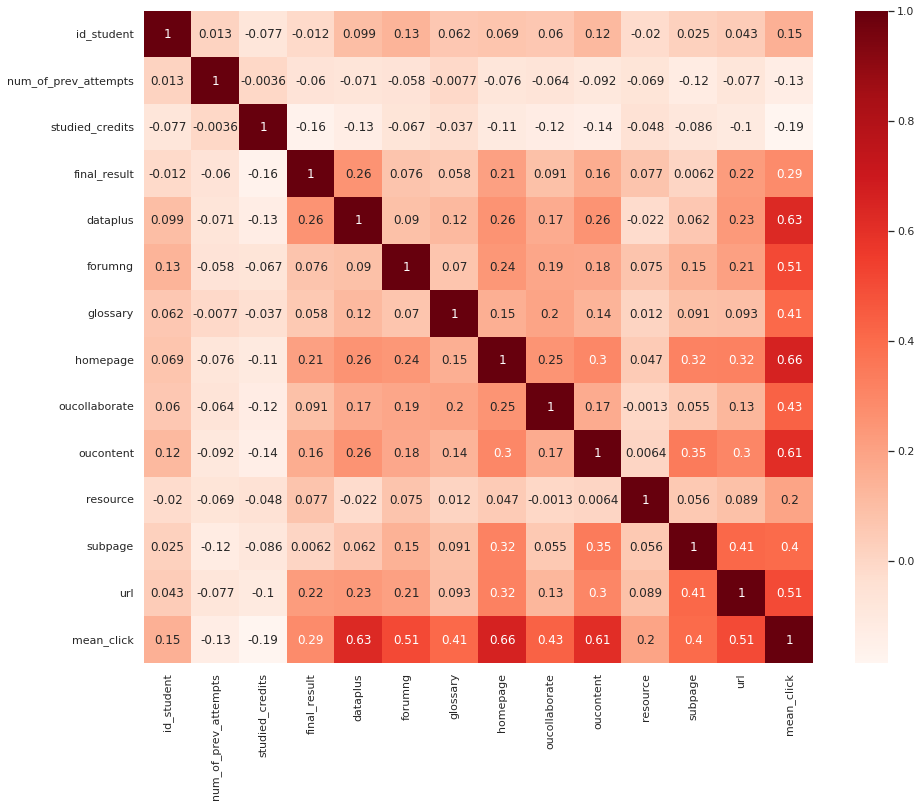

In [25]:
plt.figure(figsize=(15,12))
cor = df[-1].corr()
# cor = cor.iloc[:,-1].to_numpy().reshape(9,1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [26]:
# for index, df_day in enumerate(df):
#   df[index] = df_day.drop(['id_student', 'resource', 'studied_credits', 'homepage', 'sharedsubpage', 'num_of_prev_attempts', 'ouelluminate', 'subpage', 'url'], axis=1)
# cor = df[-1].corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

### Make predictions

In [27]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score

def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [66]:
from sklearn.pipeline import Pipeline

def encode_df(df):
  # categorise df columns
  df.gender = pd.Categorical(df.gender)
  df.region = pd.Categorical(df.region)
  df.disability = pd.Categorical(df.disability)

  encoding_pipeline = Pipeline([
      ('encoding_label',MultiColumnLabelEncoder(columns=['highest_education','imd_band','age_band'])),
  ])
  df = encoding_pipeline.fit_transform(df)

  # Convert categorical variable into indicator variables. One-hot encoding
  df = pd.get_dummies(df)

  return df

In [29]:
def split_dataset(df, train_code_presentation, test_code_presentation):   
  test_df = df.loc[df['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation'], axis = 1)

  Y_test = test_df['final_result'].replace({1:0, 2:1, 3:1})
  X_test = test_df.drop('final_result', axis=1)

  train_df = df.loc[df['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation'], axis = 1)

  Y_train = train_df['final_result'].replace({1:0, 2:1, 3:1})
  X_train = train_df.drop('final_result', axis=1)

  
  return encode_df(X_train), encode_df(X_test), Y_train, Y_test


In [30]:
from sklearn.model_selection import train_test_split

def split_dataset_single_presentation(df, code_presentation):
  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation'], axis = 1)
  
  Y = df_cp['final_result'].replace({1:0, 2:1, 3:1})
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(encode_df(X),Y)


In [31]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

#### Prepare data for prediction

In [65]:
from sklearn import preprocessing

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = preprocessing.LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = preprocessing.LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


# class MultiColumnOHEncoder:
#     def __init__(self,columns = None):
#         self.columns = columns # array of column names to encode

#     def fit(self,X,y=None):
#         return self # not relevant here

#     def transform(self,X):
#         '''
#         Transforms columns of X specified in self.columns using
#         OneHotEncoder(). If no columns specified, transforms all
#         columns in X.
#         '''
#         output = X.copy()
#         if self.columns is not None:
#             for col in self.columns:
#                 output[col] = preprocessing.OneHotEncoder().fit_transform(output[col])
#         else:
#             for colname,col in output.iteritems():
#                 output[colname] = preprocessing.OneHotEncoder().fit_transform(col)
#         return output

#     def fit_transform(self,X,y=None):
#         return self.fit(X,y).transform(X)

#### 2013J predictions

##### Random Forest Classifier

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2013J")

  randomforest = Pipeline([("scaler",StandardScaler()), ("pca",PCA(0.75)), ("rf",RandomForestClassifier())])

  #randomforest = RandomForestClassifier()
  randomforest.fit(X_train, Y_train)
  test_randomforest_predictions = randomforest.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


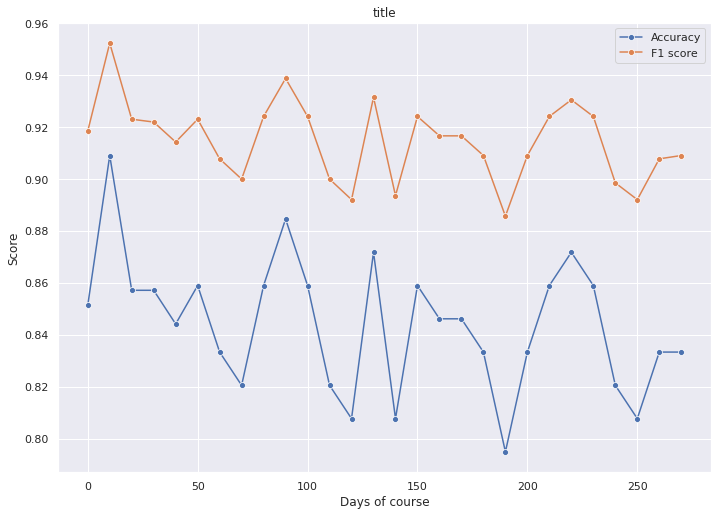

In [34]:
plot_days(deadline_list,result, "title")

In [35]:
len(result)

28

In [36]:
# print(axes[0][0])

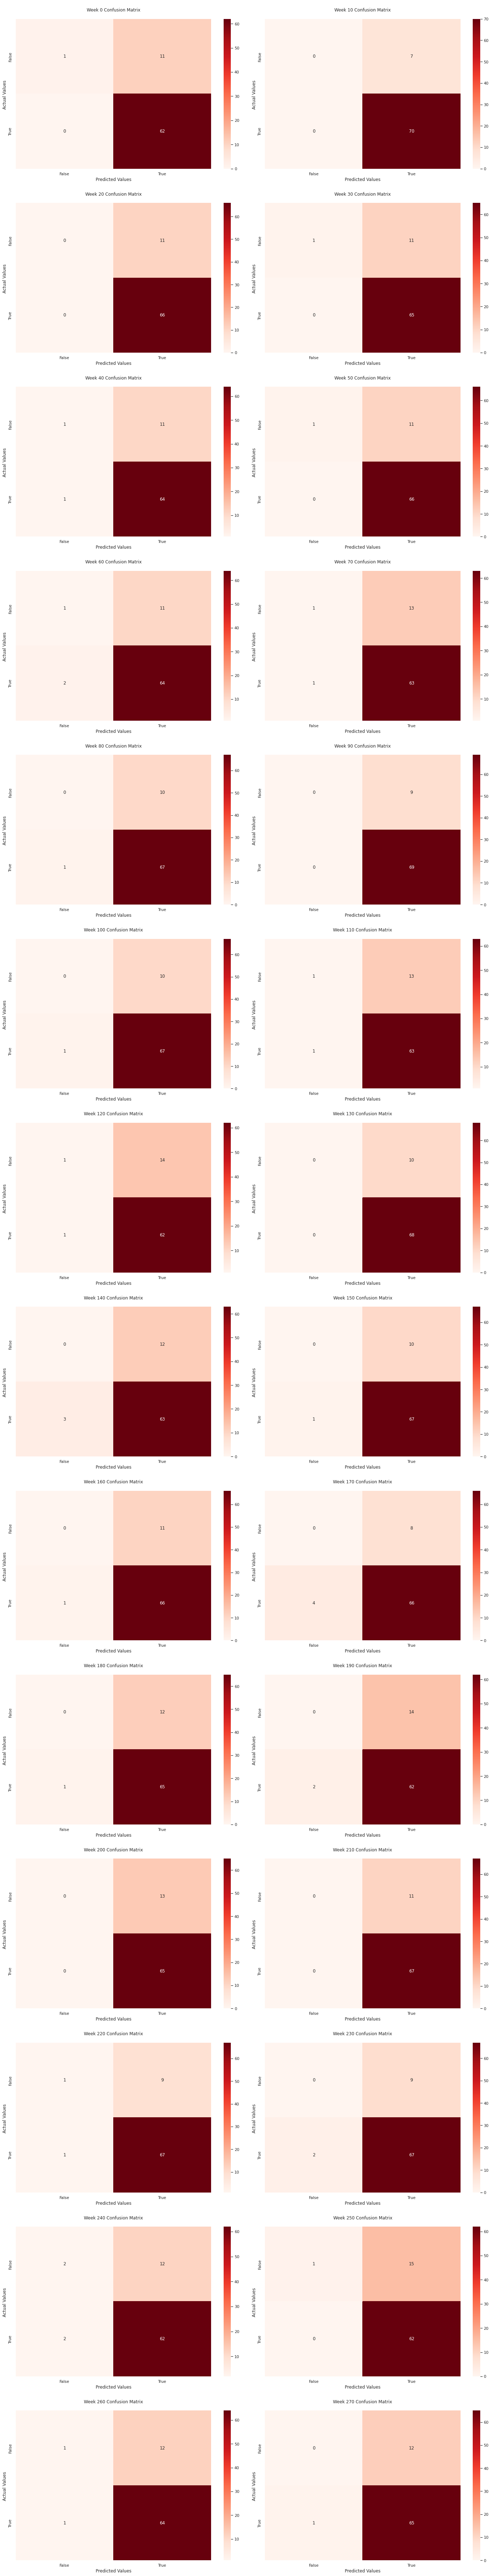

In [37]:
from sklearn.metrics import plot_confusion_matrix

fig, axes = plt.subplots(len(result)//2,2, figsize=(20, 100))

count= 0
for value, ax in zip(result, axes.flatten()):
    sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

    ax.set_title(f'\nWeek {count*10} Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values ');

    # Ticket labels - List must be in alphabetical order
    ax.set_xticklabels(['False','True'])
    ax.set_yticklabels(['False','True'])

    count+=1

plt.tight_layout()

##### Naive Bayes

In [38]:
from sklearn.naive_bayes import GaussianNB

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2013J")
  
  nb = GaussianNB()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


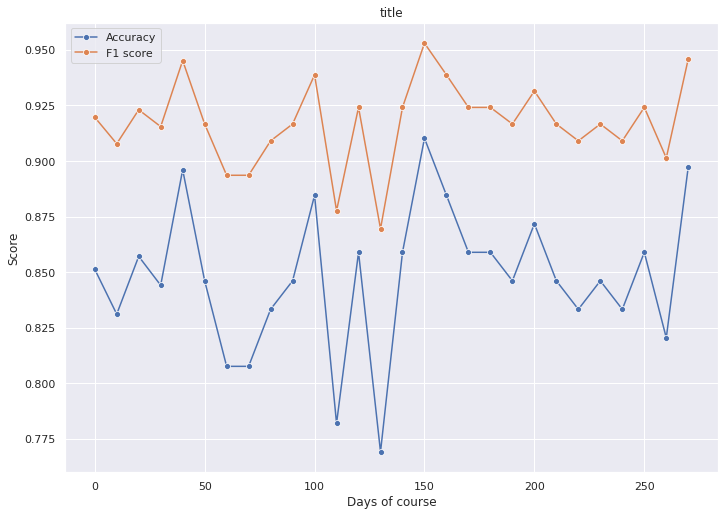

In [39]:
plot_days(deadline_list,result, "title")

##### K-Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2013J")
  
  nb = KNeighborsClassifier()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


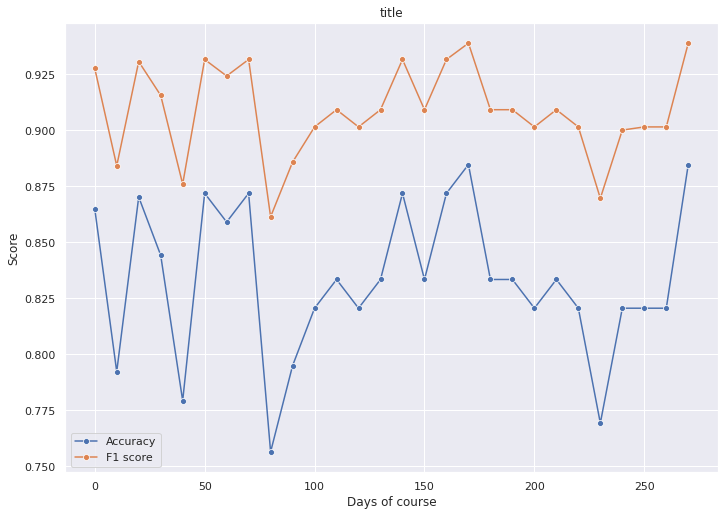

In [41]:
plot_days(deadline_list,result, "title")

#### 2014J Predictions

##### Random Forest Classifier

In [42]:
result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2014J")
  
  randomforest = Pipeline([("scaler",StandardScaler()), ("pca",PCA(0.9)), ("rf",RandomForestClassifier())])
  
  #randomforest = RandomForestClassifier()
  randomforest.fit(X_train, Y_train)
  test_randomforest_predictions = randomforest.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


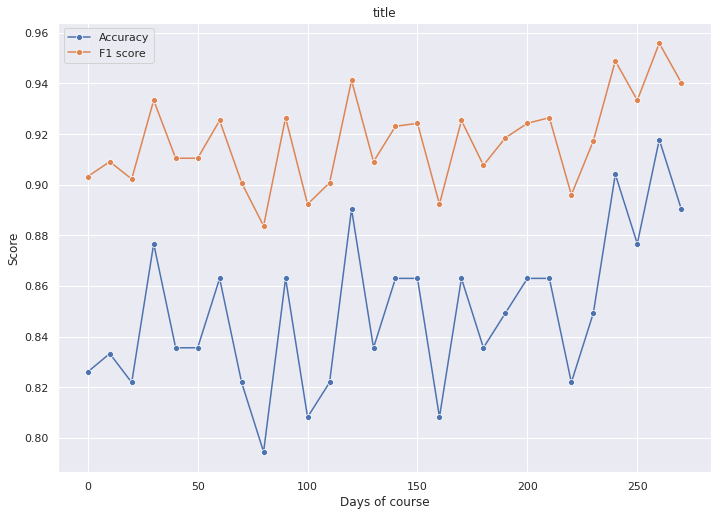

In [43]:
plot_days(deadline_list,result, "title")

##### Naive Bayes

In [44]:
from sklearn.naive_bayes import GaussianNB

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2014J")
  
  nb = GaussianNB()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


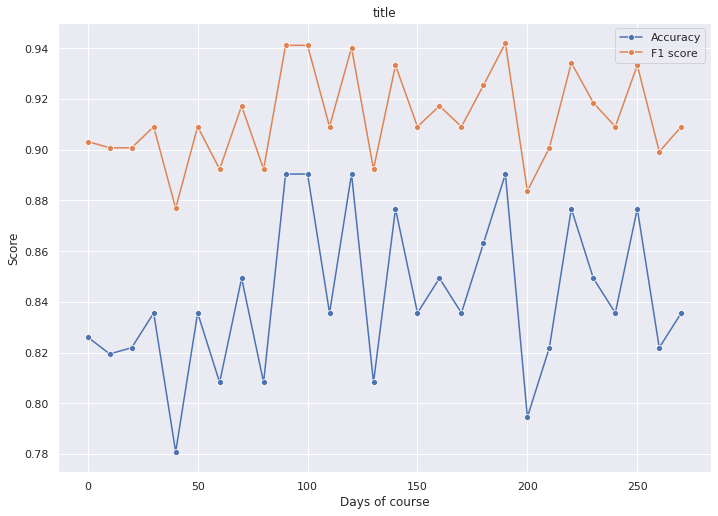

In [45]:
plot_days(deadline_list,result, "title")

##### K-Nearest Neighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset_single_presentation(df_day, "2014J")
  
  nb = KNeighborsClassifier()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


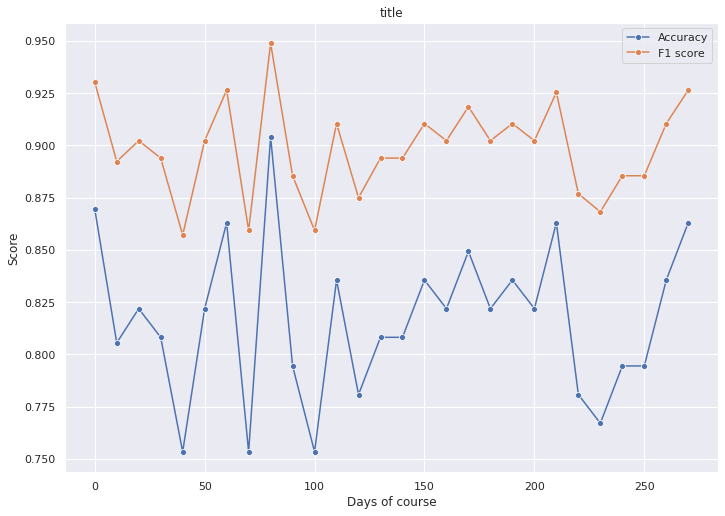

In [47]:
plot_days(deadline_list,result, "title")

#### All course presentations

**Train:** 2013J

**Test:** 2014J

##### Random Forest Classifier

In [48]:
result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset(df_day, ["2013J"],"2014J")
  
  randomforest = Pipeline([("scaler",StandardScaler()), ("pca",PCA(0.8)), ("nb",RandomForestClassifier())])

  #randomforest = RandomForestClassifier()
  randomforest.fit(X_train, Y_train)
  test_randomforest_predictions = randomforest.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_randomforest_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


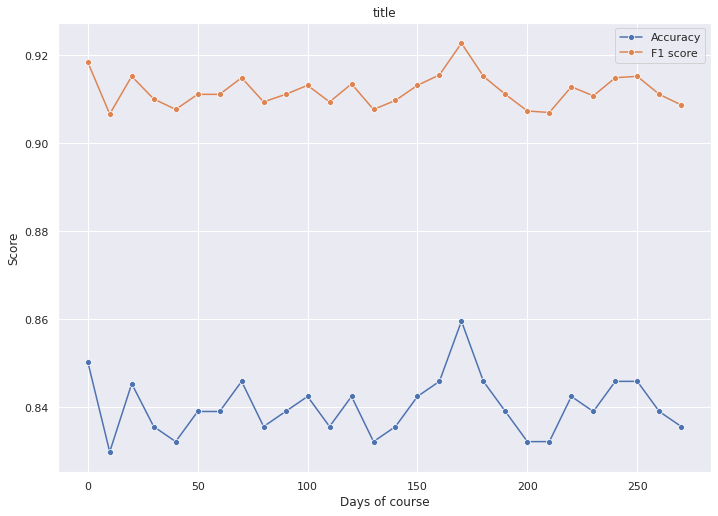

In [49]:
plot_days(deadline_list,result, "title")

##### Naive Bayes

In [50]:
from sklearn.naive_bayes import GaussianNB

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset(df_day, ["2013J"],"2014J")
  
  nb = GaussianNB()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


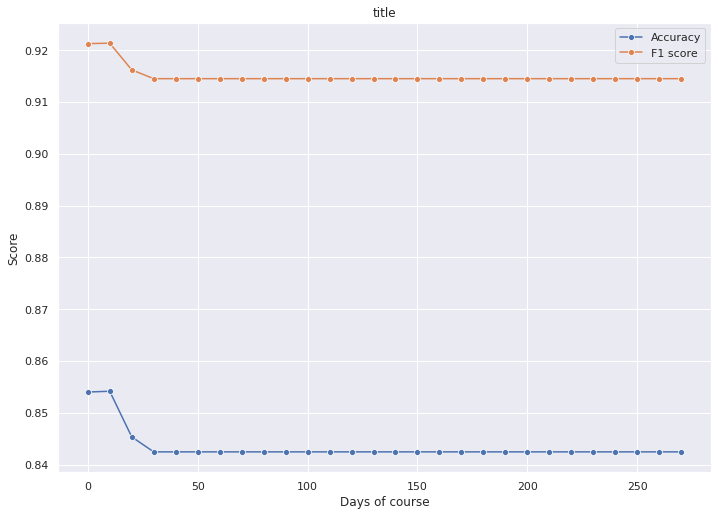

In [51]:
plot_days(deadline_list,result, "title")

##### K-Nearest Neighbors

In [52]:
from sklearn.neighbors import KNeighborsClassifier

result = []

for df_day in df:
  X_train, X_test, Y_train, Y_test = split_dataset(df_day, ["2013J"],"2014J")
  
  nb = KNeighborsClassifier()
  nb.fit(X_train, Y_train)
  test_nb_predictions = nb.predict(X_test)

  acc, f1, prec, recall, conf = evaluation_summary(test_nb_predictions, Y_test)
  result.append([acc, f1, prec, recall, conf])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


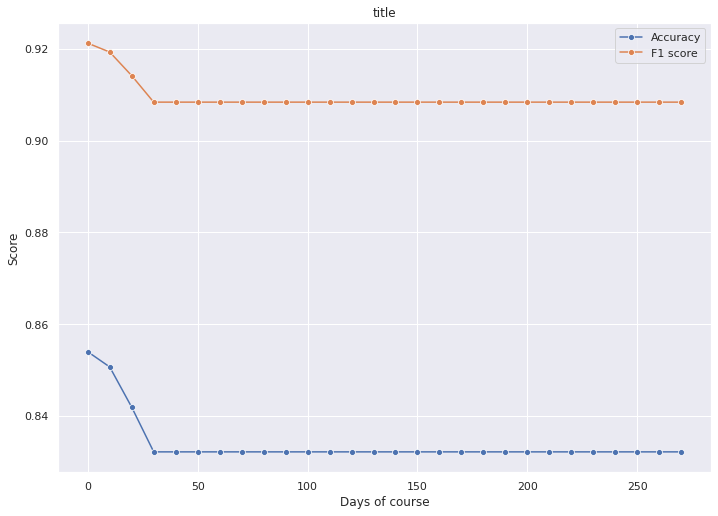

In [53]:
plot_days(deadline_list,result, "title")

# OTHER STUFF

In [135]:
len(df)

28

In [134]:
df[1].loc[df[1]['code_presentation']=="2013J"]

,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,forumng,glossary,homepage,oucollaborate,oucontent,resource,subpage,url,mean_click
0,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,2,0.0,2.714286,0.00,5.166667,0.0,10.523810,1.333333,6.666667,1.000000,1.522487
1,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,2,0.0,3.510638,0.00,7.071429,0.0,4.640000,1.000000,2.388889,1.900000,1.139498
2,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2,0.0,3.941176,1.00,5.666667,0.0,6.125000,1.666667,2.583333,1.428571,1.245079
3,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2,0.0,3.700000,2.00,5.071429,0.0,6.137931,1.000000,1.700000,1.500000,1.172742
4,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,2,0.0,4.171875,0.00,6.210526,0.0,4.840000,1.500000,2.111111,1.250000,1.115751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,2013J,2689958,M,East Anglian Region,A Level or Equivalent,40-50%,35-55,0,60,N,3,1.0,1.678571,1.00,3.650000,0.0,3.500000,1.000000,1.428571,1.250000,0.805952
302,2013J,2691206,F,West Midlands Region,A Level or Equivalent,50-60%,0-35,0,60,N,3,0.0,2.642857,2.25,4.812500,0.0,5.685714,1.250000,1.833333,1.000000,1.081911
303,2013J,2691244,M,South Region,A Level or Equivalent,40-50%,35-55,0,180,N,2,0.0,1.666667,0.00,1.857143,0.0,3.833333,1.000000,1.000000,0.000000,0.519841
304,2013J,2694424,M,East Anglian Region,A Level or Equivalent,70-80%,35-55,0,120,N,2,0.0,6.277778,0.00,5.200000,0.0,3.666667,0.000000,1.333333,0.000000,0.915432


In [138]:
df_cp = df[0].loc[df[0]['code_presentation']=="2013J"]
df_cp = df_cp[["id_student"]]
df_cp['final_result'] = df[0].loc[df[0]['code_presentation']=="2013J"].final_result.replace({1:0, 2:1, 3:1})

for i in range(len(df)):
  print(i)
  df_cp[f'mean_click_{i}'] = df[i].loc[df[i]['code_presentation']=="2013J"].mean_click


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


In [139]:
df_cp

,id_student,final_result,mean_click_0,mean_click_1,mean_click_2,mean_click_3,mean_click_4,mean_click_5,mean_click_6,mean_click_7,mean_click_8,mean_click_9,mean_click_10,mean_click_11,mean_click_12,mean_click_13,mean_click_14,mean_click_15,mean_click_16,mean_click_17,mean_click_18,mean_click_19,mean_click_20,mean_click_21,mean_click_22,mean_click_23,mean_click_24,mean_click_25,mean_click_26,mean_click_27
0,11391,1,1.894444,1.522487,1.524420,1.443034,1.363113,1.355850,1.266580,1.268816,1.262334,1.228784,1.214662,1.187978,1.187978,1.177784,1.118895,1.118895,1.111943,1.111943,1.111943,1.123373,1.119056,1.108121,1.108121,1.116558,1.116314,0.985715,0.982574,0.982574
1,28400,1,1.181481,1.139498,1.169808,1.196346,1.148485,1.130317,1.058702,1.022467,1.015145,0.999744,0.940777,0.924789,0.922950,0.904486,1.008166,0.984447,0.995563,0.982635,0.981514,0.991950,1.021342,1.013513,1.021379,1.017756,1.015826,1.015826,1.015826,1.015826
2,31604,1,1.355093,1.245079,1.128592,1.084262,1.051651,1.040073,0.971236,1.000680,0.983097,0.966133,0.961048,0.954749,0.951555,0.957745,0.908711,1.001491,0.991440,0.979398,0.972471,0.971837,0.973612,0.966441,0.966340,0.966024,0.966267,0.965582,0.964475,0.962315
3,32885,1,1.345281,1.172742,1.107699,1.056590,1.055905,1.055905,0.981889,0.974199,0.952604,0.945660,0.941010,1.019043,1.019043,0.981166,0.923298,0.917581,0.915285,0.907560,0.901005,0.840524,0.836483,0.830498,0.824053,0.812278,0.805520,0.801253,0.801253,0.801253
4,38053,1,1.234362,1.115751,1.051900,1.019251,0.977779,0.964933,1.278481,1.259451,1.251130,1.246495,1.247569,1.239899,1.228153,1.222359,1.159153,1.160694,1.151950,1.146940,1.143295,1.134698,1.128055,1.120897,1.254934,1.256327,1.248367,1.244138,1.241598,1.237208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2689958,1,0.855886,1.631129,1.219464,1.460377,1.400089,1.344641,1.243070,1.226078,1.208335,1.180009,1.147968,1.124915,1.105118,1.127683,1.057043,1.097526,1.084719,1.076914,1.069326,1.060023,1.053250,1.033526,1.034030,1.033583,1.026120,1.024863,1.024863,1.024331
292,2691206,1,1.053333,0.590741,1.531399,1.175319,1.187629,1.359731,1.261245,1.238295,1.232736,1.215194,1.209983,1.209983,1.195635,1.176088,1.208687,1.207386,1.176959,1.198117,1.194309,1.196181,1.182605,1.177649,1.176034,1.165869,1.155223,1.159386,1.157422,1.157422
293,2691244,1,0.416667,0.615741,0.719937,1.524980,1.447629,1.139605,1.031849,1.027693,1.032007,1.011804,0.970449,0.953107,0.941301,0.947171,0.886555,0.875453,0.864495,0.850267,0.839644,0.835068,0.845691,0.847161,0.862992,0.867003,0.861885,0.850108,0.846787,0.846279
294,2694424,1,0.694444,1.209722,0.856385,0.690311,0.670153,1.414785,1.331036,1.291810,1.304805,1.279635,1.307505,1.307737,1.296402,1.318518,1.277545,1.260022,1.253201,1.239097,1.231025,1.221175,1.212909,1.198783,1.175084,1.175416,1.161428,1.158370,1.155675,1.152776


In [142]:
PERCENT_DROP = 10

def drop_previous_week(row, week):
  prev_week = row[f'mean_click_{week-1}']
  curr_week = row[f'mean_click_{week}']
  percent_drop_week = ((prev_week-curr_week)/abs(prev_week))*100

  if percent_drop_week >= PERCENT_DROP:
    significant_drop = True
  else:
    significant_drop = False

  #print(prev_week, curr_week, significant_drop, percent_drop_week,row['final_result'])

  return significant_drop#, row['final_result']

#print("prev_week", "curr_week", "significant_drop", "percent_drop_week", "final_result")

drop_df = df_cp[['id_student','final_result']]
for week in range(1, len(df)):
  drop_df[f'week_{week*10}'] = df_cp.apply(lambda row : drop_previous_week(row, week), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [143]:
drop_df

,id_student,final_result,week_10,week_20,week_30,week_40,week_50,week_60,week_70,week_80,week_90,week_100,week_110,week_120,week_130,week_140,week_150,week_160,week_170,week_180,week_190,week_200,week_210,week_220,week_230,week_240,week_250,week_260,week_270
0,11391,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
1,28400,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,31604,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,32885,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,38053,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2689958,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
292,2691206,1,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
293,2691244,1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
294,2694424,1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [153]:
drop_df.loc[drop_df['final_result'] == 0]


,id_student,final_result,week_10,week_20,week_30,week_40,week_50,week_60,week_70,week_80,week_90,week_100,week_110,week_120,week_130,week_140,week_150,week_160,week_170,week_180,week_190,week_200,week_210,week_220,week_230,week_240,week_250,week_260,week_270
14,74372,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
40,146188,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
41,147756,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
50,175991,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
55,185439,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
62,205719,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
73,241729,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
83,268073,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
87,281250,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
88,281589,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [150]:
PERCENT_DIFF = 10

def drop_previous_week(row, class_average, week):
  curr_week_avg = row[f'mean_click_{week}']

  percent_diff_week = ((class_average-curr_week_avg)/abs(class_average))*100


  if percent_diff_week >= PERCENT_DIFF:
    significant_diff = True
  else:
    significant_diff = False

  # if row['final_result'] == 1.0:
  #   print(curr_week_avg, significant_drop,percent_diff_week, row['final_result'])

  return significant_diff


diff_df = df_cp[['id_student','final_result']]
for week in range(0, len(df)):
  class_average = df_cp[f'mean_click_{week}'].mean()
  diff_df[f'week_{week*10}'] = df_cp.apply(lambda row : drop_previous_week(row, class_average, week), axis=1)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [151]:
diff_df

,id_student,final_result,week_0,week_10,week_20,week_30,week_40,week_50,week_60,week_70,week_80,week_90,week_100,week_110,week_120,week_130,week_140,week_150,week_160,week_170,week_180,week_190,week_200,week_210,week_220,week_230,week_240,week_250,week_260,week_270
0,11391,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,28400,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,31604,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,32885,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True
4,38053,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,2689958,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
292,2691206,1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
293,2691244,1,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False
294,2694424,1,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [152]:
diff_df.loc[diff_df['final_result'] == 0]


,id_student,final_result,week_0,week_10,week_20,week_30,week_40,week_50,week_60,week_70,week_80,week_90,week_100,week_110,week_120,week_130,week_140,week_150,week_160,week_170,week_180,week_190,week_200,week_210,week_220,week_230,week_240,week_250,week_260,week_270
14,74372,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
40,146188,0,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True
41,147756,0,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
50,175991,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
55,185439,0,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
62,205719,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
73,241729,0,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
83,268073,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
87,281250,0,True,True,True,True,False,False,True,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
88,281589,0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [ ]:
# from sklearn.inspection import permutation_importance

# importance = permutation_importance(randomforest, X_test, Y_test)
# print(importance.importances_mean)

# feature_names = randomforest.feature_names_in_

# plt.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
# plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
# plt.show()

# importance_table = pd.DataFrame({'importance': importance['importances_mean'],
#                                  'column': feature_names })
# importance_table.sort_values(by = 'importance', ascending = False)[:20]